# KCCA Tutorial

This algorithm runs KCCA on two views of data. The kernel implementations, parameter 'ktype', are linear, polynomial and gaussian. Linear kernel has one parameter: 'constant'. Polynomial kernel has two parameters: 'constant', 'degree'. Gaussian kernel has one parameter: 'sigma'.

When initializing KCCA, you can also initialize the following parameters: the regularization parameter 'reg' and the number of canonical components 'n_components'.

In [1]:
%matplotlib inline
import numpy as np
import sys
sys.path.append("../../..")
from mvlearn.embed.kcca import KCCA
import matplotlib.pyplot as plt
from scipy import stats

/Users/theodorelee/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


Function creates Xs, a list of two views of data with a linear relationship, polynomial relationship (2nd degree) and a gaussian relationship.

In [2]:
def make_data(kernel, N):
    # # # Define two latent variables (number of samples x 1)
    latvar1 = np.random.randn(N,)
    latvar2 = np.random.randn(N,)
    
    # # # Define independent components for each dataset (number of observations x dataset dimensions)
    indep1 = np.random.randn(N, 4)
    indep2 = np.random.randn(N, 5)
    
    if kernel == "linear":
        x = 0.25*indep1 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2)).T
        y = 0.25*indep2 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2, latvar1)).T
        
        return [x,y]
    
    elif kernel == "poly":
        x = 0.25*indep1 + 0.75*np.vstack((latvar1**2, latvar2**2, latvar1**2, latvar2**2)).T
        y = 0.25*indep2 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2, latvar1)).T
        
        return [x,y]
    
    elif kernel == "gaussian":
        t = np.random.uniform(-np.pi, np.pi, N)
        e1 = np.random.normal(0, 0.05, (N,2))
        e2 = np.random.normal(0, 0.05, (N,2))
        
        x = np.zeros((N,2))
        x[:,0] = t
        x[:,1] = np.sin(3*t)
        x += e1
        
        y = np.zeros((N,2))
        y[:,0] = np.exp(t/4)*np.cos(2*t)
        y[:,1] = np.exp(t/4)*np.sin(2*t)
        y += e2
        
        return [x,y]

# Linear kernel implementation

In [5]:
Xs = make_data('linear', 100)
kcca_l = KCCA(ktype ="linear", constant = 100.0, n_components = 4)
linearkcca = kcca_l.fit_transform(Xs)

([], <a list of 0 Text major ticklabel objects>)

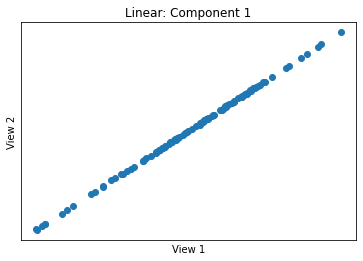

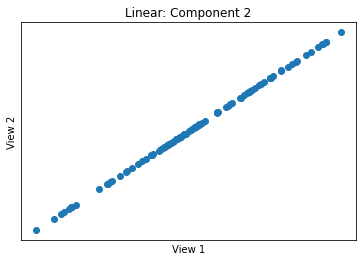

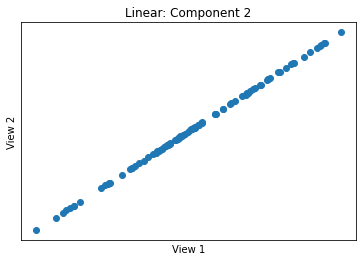

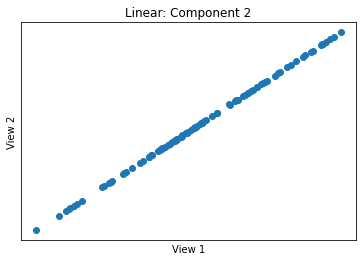

In [6]:
fig = plt.figure()
plt.scatter(linearkcca[0][:,0], linearkcca[1][:,0])
plt.title('Linear: Component 1')
plt.xlabel('View 1')
plt.ylabel('View 2')
plt.xticks([])
plt.yticks([])

fig = plt.figure()
plt.scatter(linearkcca[0][:,1], linearkcca[1][:,1])
plt.title('Linear: Component 2')
plt.xlabel('View 1')
plt.ylabel('View 2')
plt.xticks([])
plt.yticks([])

fig = plt.figure()
plt.scatter(linearkcca[0][:,2], linearkcca[1][:,2])
plt.title('Linear: Component 2')
plt.xlabel('View 1')
plt.ylabel('View 2')
plt.xticks([])
plt.yticks([])

fig = plt.figure()
plt.scatter(linearkcca[0][:,3], linearkcca[1][:,3])
plt.title('Linear: Component 2')
plt.xlabel('View 1')
plt.ylabel('View 2')
plt.xticks([])
plt.yticks([])

In [7]:
(r1, _) = stats.pearsonr(linearkcca[0][:,0], linearkcca[1][:,0])
(r2, _) = stats.pearsonr(linearkcca[0][:,1], linearkcca[1][:,1])
(r3, _) = stats.pearsonr(linearkcca[0][:,2], linearkcca[1][:,2])
(r4, _) = stats.pearsonr(linearkcca[0][:,3], linearkcca[1][:,3])

print("Below are the canonical correlation for the four components:")
print(r1,r2,r3,r4)

Below are the canonical correlation for the four components:
0.9999585123077844 0.9999877753768546 0.9999871646667249 0.9999898489176582


# Polynomial kernel implementation

In [8]:
Xsp = make_data("poly", 100)
kcca_p = KCCA(ktype ="poly", constant = 100.0, degree = 2.0, n_components = 2)
polykcca = kcca_p.fit_transform(Xsp)

([], <a list of 0 Text major ticklabel objects>)

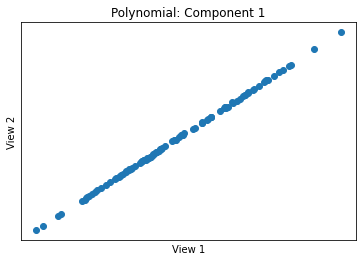

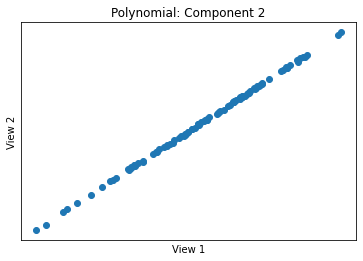

In [9]:
fig = plt.figure()
plt.scatter(polykcca[0][:,0], polykcca[1][:,0])
plt.title('Polynomial: Component 1')
plt.xlabel('View 1')
plt.ylabel('View 2')
plt.xticks([])
plt.yticks([])

fig = plt.figure()
plt.scatter(polykcca[0][:,1], polykcca[1][:,1])
plt.title('Polynomial: Component 2')
plt.xlabel('View 1')
plt.ylabel('View 2')
plt.xticks([])
plt.yticks([])

In [10]:
(pr1, _) = stats.pearsonr(polykcca[0][:,0], polykcca[1][:,0])
(pr2, _) = stats.pearsonr(polykcca[0][:,1], polykcca[1][:,1])


print("Below are the canonical correlation for the two components:")
print(pr1,pr2)

Below are the canonical correlation for the two components:
0.9999287423214721 0.9998432128397636


# Gaussian Kernel Implementation

In [13]:
Xsg = make_data("gaussian", 100)
kcca_g = KCCA(ktype ="gaussian", sigma = 3.0, n_components = 2)
gausskcca = kcca_g.fit_transform(Xsg)

([], <a list of 0 Text major ticklabel objects>)

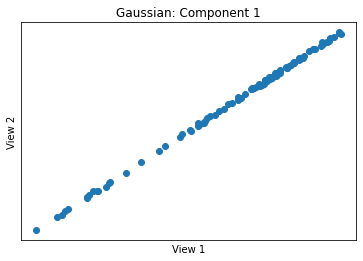

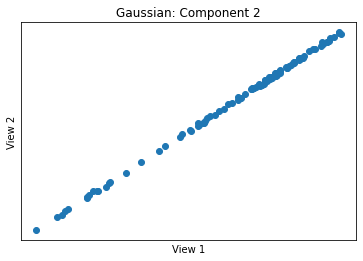

In [14]:
fig = plt.figure()
plt.scatter(gausskcca[0][:,0], gausskcca[1][:,0])
plt.title('Gaussian: Component 1')
plt.xlabel('View 1')
plt.ylabel('View 2')
plt.xticks([])
plt.yticks([])

fig = plt.figure()
plt.scatter(gausskcca[0][:,1], gausskcca[1][:,1])
plt.title('Gaussian: Component 2')
plt.xlabel('View 1')
plt.ylabel('View 2')
plt.xticks([])
plt.yticks([])

In [15]:
(gr1, _) = stats.pearsonr(gausskcca[0][:,0], gausskcca[1][:,0])
(gr2, _) = stats.pearsonr(gausskcca[0][:,1], gausskcca[1][:,1])

print("Below are the canonical correlation for the two components:")
print(gr1,gr2)

Below are the canonical correlation for the two components:
0.9998036823036847 0.9998036823036847
